# Исследование выборки данных о пользователях и поездках сервиса GoFast

В распоряжение дана выборка данных о пользователях и поездках сервиса аренды самокатов GoFast. Данные содержатся в 3 таблицах с соответствующими столбцами:
- `/datasets/users_go.csv`
    - `user_id`	уникальный идентификатор пользователя
    - `name`	имя пользователя
    - `age`	возраст
    - `city`	город
    - `subscription_type`	тип подписки (free, ultra)
- `/datasets/rides_go.csv`
    - `user_id`	уникальный идентификатор пользователя
    - `distance`	расстояние, которое пользователь проехал в текущей сессии (в метрах)
    - `duration`	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
    - `date`	дата совершения поездки
- `/datasets/subscriptions_go.csv`
    - `subscription_type`	тип подписки
    - `minute_price`	стоимость одной минуты поездки по данной подписке
    - `start_ride_price`	стоимость начала поездки
    - `subscription_fee`	стоимость ежемесячного платежа

## Цели исследования
- Рассмотрение общей инфрмации о пользователях и поездках:
    - Частота встречаемости городов
    - Соотношение пользователей с подпиской и без
    - Возраст пользователей
    - Расстояние и длительность поездок
- Рассмотрение дальности и длительности поездок по отдельности для пользователей с подпиской без
- Подсчет выручки для пользователей с различными подписками
- Проверка гипотез
    - Расстояние одной поездки менее 3130 м
    - Пользователи с подпиской тратят больше времени на поездки
    - Помесячная выручка от пользователей с подпиской выше
- Ответы на вопросы отдела маркетинга (сформулированы в соответствующей главе)

## Ход работы

**Общий план исследования:**
- Загрузка данных
- Предобработка данных (оценка их качестваи при необходимости исправление)
- Исследовательский анализ данных (рассмотрение общих данных о пользователях и  поездках)
- Объединение данных о пользователях и поездках в единый датафрейм и разделение его на 2 суб-датафрейма с данными о пользователях с подпиской и  без
- Подсчет выручки
- Проверка гипотез
- Ответы на вопросы отдела маркетинга
- Выводы

### Подготовка к работе

In [1]:
import pandas as pd

import numpy as np

from matplotlib import pyplot as plt

from scipy import stats as st

### Загрузка и обзор данных

Будем рассматривать срез данных о пользователях сервиса аренды самокатов GoFast. Данные содержатся в 3 таблицах с соответствующими столбцами:
- `/datasets/users_go.csv`
    - `user_id`	уникальный идентификатор пользователя
    - `name`	имя пользователя
    - `age`	возраст
    - `city`	город
    - `subscription_type`	тип подписки (free, ultra)
- `/datasets/rides_go.csv`
    - `user_id`	уникальный идентификатор пользователя
    - `distance`	расстояние, которое пользователь проехал в текущей сессии (в метрах)
    - `duration`	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
    - `date`	дата совершения поездки
- `/datasets/subscriptions_go.csv`
    - `subscription_type`	тип подписки
    - `minute_price`	стоимость одной минуты поездки по данной подписке
    - `start_ride_price`	стоимость начала поездки
    - `subscription_fee`	стоимость ежемесячного платежа

#### Загрузка данных

In [2]:
users = pd.read_csv('...')
rides = pd.read_csv('...')
subscriptions = pd.read_csv('...')

#### Обзор данных

In [3]:
display(users.head())
display(rides.head())
display(subscriptions.head())

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Как видно данные совпадают с предоставленным описанием структуры данных.

Из последней таблицы получаем, что сервисом можно пользоваться:
- **без подписки**
    - абонентская плата отсутствует;
    - стоимость одной минуты поездки — 8 рублей;
    - стоимость старта (начала поездки) — 50 рублей;
- **с подпиской Ultra**
    - абонентская плата — 199 рублей в месяц;
    - стоимость одной минуты поездки — 6 рублей;
    - стоимость старта — бесплатно.

### Предобработка данных

Рассмотрим пропуски в данных и проведем преобразование типов. Также проверим что для каждого `user_id` в таблице `rides` есть данные об этом пользователе в таблице `users`

In [4]:
print('Число пропусков в столбцах таблицы users')
print(users.isna().sum())
display(users.info())

print('Число пропусков в столбцах таблицы rides')
print(rides.isna().sum())
display(rides.info())

print('Число пропусков в столбцах таблицы subscriptions')
print(subscriptions.isna().sum())
display(subscriptions.info())

print('для каждого user_id в таблице rides есть данные об этом пользователе в таблице users:',np.array_equal(np.sort(rides['user_id'].unique()), np.sort(users['user_id'].unique())))

Число пропусков в столбцах таблицы users
user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


None

Число пропусков в столбцах таблицы rides
user_id     0
distance    0
duration    0
date        0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


None

Число пропусков в столбцах таблицы subscriptions
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


None

для каждого user_id в таблице rides есть данные об этом пользователе в таблице users: True


Приведем данные в столбце `date` к типу `datetime` и добавим столбец `month` с номером месяца в который была совершена поездка. Также посмотрим за какие года доступны данные.

Отбросим все строки с повторяющимся `user_id` из таблицы `users` и удалим все явные дубликаты из таблицы `rides`.

In [5]:
rides['date'] = pd.to_datetime(rides['date'],format='%Y-%m-%d')
rides['month'] = rides['date'].dt.month

print('В выборке доступны данные за годы:', rides['date'].dt.year.unique())

print('Число явных дубликатов в таблице rides:', rides.duplicated().sum())
rides = rides.drop_duplicates()

print('Число пользователей с одинаковым user_id в таблице users(считается ошибкой):', users.duplicated(subset='user_id').sum())
users = users.drop_duplicates(subset='user_id')

В выборке доступны данные за годы: [2021]
Число явных дубликатов в таблице rides: 0
Число пользователей с одинаковым user_id в таблице users(считается ошибкой): 31


С данными все хорошо и никаких пропусков нет, для каждого `user_id` в таблице `rides` есть данные об этом пользователе в таблице `users`.

В выборке находятся данные только за 2021 год.

Явных дубликатов в таблице `rides` нет.

Обнаружилось, что в таблице `users` есть пользователи с одинаковыми `user_id`, удалим из нее все строки с повторяющимся `user_id`

### Исследовательский анализ данных

Опишем общую информацию о пользователях и поездках

#### Частота встречаемости городов

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

<AxesSubplot:title={'center':'Число пользователей в различных городах'}, xlabel='Города', ylabel='Число пользователей'>

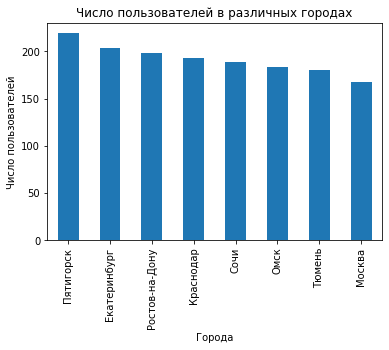

In [6]:
display(users['city'].value_counts())

users['city'].value_counts().plot(kind='bar', xlabel='Города', ylabel='Число пользователей', title='Число пользователей в различных городах')

Наибольшее число пользователей в выборке зарегистрировано в Пятигорске (219), а наименьшее в Москве (168). Всего в выборку попали пользователи из 8 городов

#### Соотношение пользователей с подпиской и без подписки


free     835
ultra    699
Name: subscription_type, dtype: int64

Процент пользователей с платной подпиской: 45.56714471968709


<AxesSubplot:title={'center':'Число пользователей с различными подписками'}, xlabel='Тип подписки', ylabel='Число пользователей'>

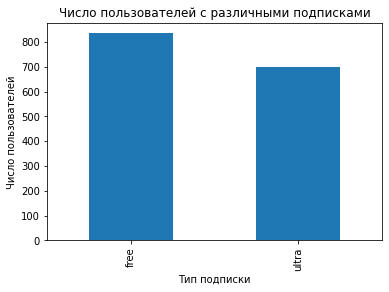

In [7]:
display(users['subscription_type'].value_counts())

print('Процент пользователей с платной подпиской:', users.query('subscription_type=="ultra"')['subscription_type'].count()/users['subscription_type'].count()*100)

users['subscription_type'].value_counts().plot(kind='bar', xlabel='Тип подписки', ylabel='Число пользователей', title='Число пользователей с различными подписками')

В выборку попало 1534 пользователя, среди которых платную подписку имеют 45.6% пользователей.

#### Возраст пользователей

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

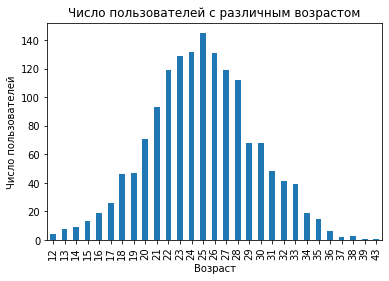

In [8]:
users['age'].value_counts(sort=False).plot(kind='bar', xlabel='Возраст', ylabel='Число пользователей', title='Число пользователей с различным возрастом')

users['age'].describe()

Возраст пользователей в выборке варьируется от 12 до 43 лет, средний возраст практически совпадает с медианным (24.9 против 25), внешне распределение близко к нормальному со стандартным отклонением 4.6.

#### Расстояние, которое пользователь преодолел за одну поездку

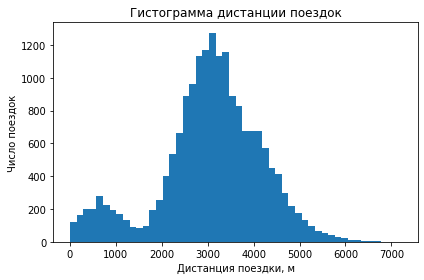

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

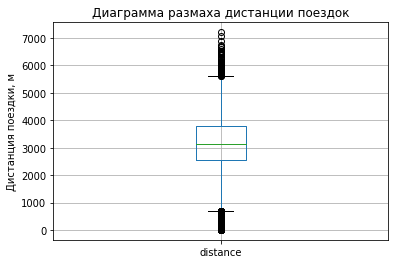

In [9]:
#rides.hist('distance', bins = 50)

fig, ax = plt.subplots()

ax.hist(rides['distance'], bins=50)

ax.set_xlabel('Дистанция поездки, м')
ax.set_ylabel('Число поездок')
ax.set_title('Гистограмма дистанции поездок')
fig.tight_layout()
plt.show()

bplot = rides.boxplot('distance')
bplot.set_ylabel('Дистанция поездки, м')
bplot.set_title('Диаграмма размаха дистанции поездок')

rides['distance'].describe()

Плотность распределения пройденного расстояния в выборке имеет 2 пика: большой около 3км и малый около 700м, и, за исключением малого пика, похоже на нормальное. Медианная и средняя дальность поездки близки и составляют около 3.1км.
Размах длительности поездок составляет от 0 до 7км

#### Продолжительность поездок

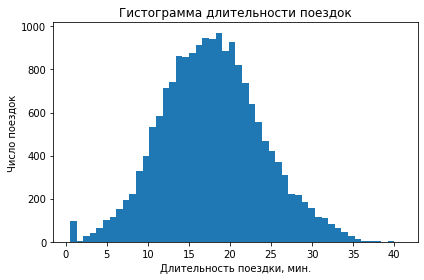

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

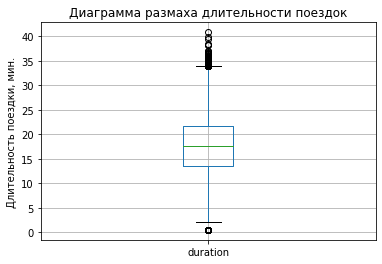

In [10]:
#rides.hist('duration', bins = 50)

fig, ax = plt.subplots()

ax.hist(rides['duration'], bins=50)

ax.set_xlabel('Длительность поездки, мин.')
ax.set_ylabel('Число поездок')
ax.set_title('Гистограмма длительности поездок')
fig.tight_layout()
plt.show()

bplot = rides.boxplot('duration')
bplot.set_ylabel('Длительность поездки, мин.')
bplot.set_title('Диаграмма размаха длительности поездок')

rides['duration'].describe()

Плотность распределения длительности поездки в выборке похоже на нормальное со средним значением 17.8 (медиана 17.7) и стандартным отклонением 6.1.
Размах продолжительности поездок составляет от 1 до 41 минут.

### Объединение данных

Объединим данные из таблиц в 3 датафрейма, содержащих данные о всех пользователях и поездках и о пользователях с подпиской и без подписки соответстенно.

In [11]:
print('Размер таблицы rides:', rides.shape)
print('Размер таблицы users:', users.shape)

full = pd.merge(rides, users, on='user_id', how='right')

print('Размер таблицы full:', full.shape)

free = full.loc[full['subscription_type'] =="free"]
ultra = full.loc[full['subscription_type'] =="ultra"]

print('Пропуски в таблице full:', full.isna().sum())

display(free.head())
display(ultra.head())

Размер таблицы rides: (18068, 5)
Размер таблицы users: (1534, 5)
Размер таблицы full: (18068, 9)
Пропуски в таблице full: user_id              0
distance             0
duration             0
date                 0
month                0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64


,user_id,distance,duration,date,month,name,age,city,subscription_type
6500,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free
6501,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free
6502,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free
6503,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free
6504,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free


,user_id,distance,duration,date,month,name,age,city,subscription_type
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra


Как и ожидалось, число строк в датафрейме после склейки `full` осталось таким же как и у таблицы `users`, а число столбцов естественно увеличилось. После объединения таблиц в результирующем датафрейме пропусков нет

Рассмотрим длительность и дистанцию поездок для каждого из видов подписок

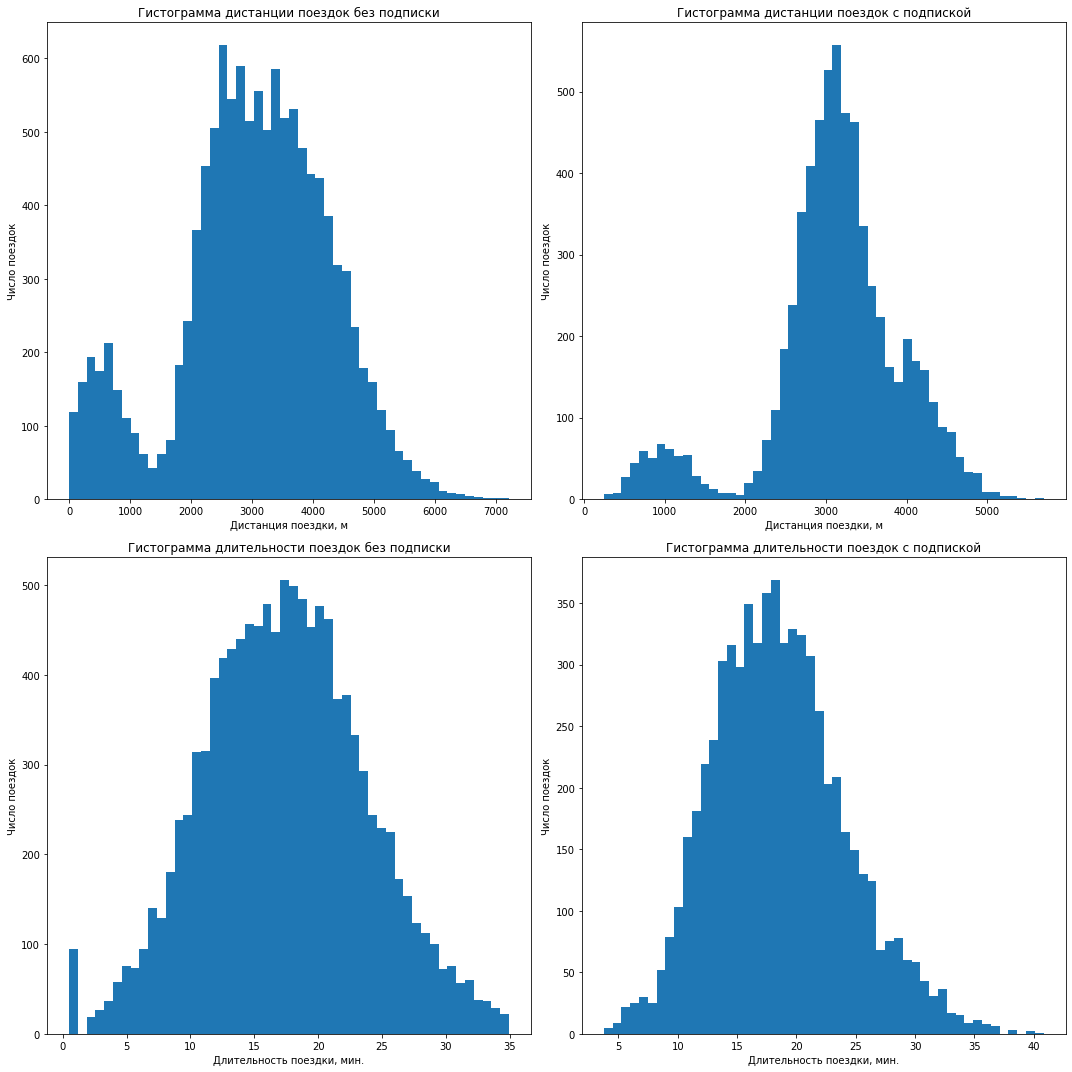

Всего поездок в выборке с бесплатной подпиской: 11568
Всего поездок в выборке с платной подпиской: 6500
Средний пробег в выборке с бесплатной подпиской: 3045.495281671816
Средний пробег в выборке с платной подпиской: 3115.4453880370247
Суммарный пробег в выборке с бесплатной подпиской: 35230289.41837957
Суммарный пробег в выборке с платной подпиской: 20250395.02224066


In [12]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_figheight(15)
fig.set_figwidth(15)

axes[0,0].hist(free['distance'], bins=50)
axes[0,0].set_xlabel('Дистанция поездки, м')
axes[0,0].set_ylabel('Число поездок')
axes[0,0].set_title('Гистограмма дистанции поездок без подписки')

axes[0,1].hist(ultra['distance'], bins=50)
axes[0,1].set_xlabel('Дистанция поездки, м')
axes[0,1].set_ylabel('Число поездок')
axes[0,1].set_title('Гистограмма дистанции поездок с подпиской')

axes[1,0].hist(free['duration'], bins=50)
axes[1,0].set_xlabel('Длительность поездки, мин.')
axes[1,0].set_ylabel('Число поездок')
axes[1,0].set_title('Гистограмма длительности поездок без подписки')

axes[1,1].hist(ultra['duration'], bins=50)
axes[1,1].set_xlabel('Длительность поездки, мин.')
axes[1,1].set_ylabel('Число поездок')
axes[1,1].set_title('Гистограмма длительности поездок с подпиской')

#free.hist('distance', ax = axes[0,0], bins=50) 
#ultra.hist('distance', ax = axes[0,1], bins=50)
#free.hist('duration', ax = axes[1,0], bins=50) 
#ultra.hist('duration', ax = axes[1,1], bins=50)

fig.tight_layout()
plt.show()

print('Всего поездок в выборке с бесплатной подпиской:', free['distance'].count())
print('Всего поездок в выборке с платной подпиской:', ultra['distance'].count())

print('Средний пробег в выборке с бесплатной подпиской:', free['distance'].mean())
print('Средний пробег в выборке с платной подпиской:', ultra['distance'].mean())

print('Суммарный пробег в выборке с бесплатной подпиской:', free['distance'].sum())
print('Суммарный пробег в выборке с платной подпиской:', ultra['distance'].sum())

Слева изображены гистограммы выборок для бесплатной, а справа для платной подписок.

Заметим что общий вид распределений и середины пиков для дистанции и времени поездки не изменились, однако для платной подписки колоколы распределений оказались уже чем для бесплатной.

Заметим также, что среди пользователей с платной подпиской минимальная дистанция и максимальное и минимальное время поездки больше чем для бесплатной (1-35 минут для бесплатной и 3-41 для платной; менее 1м для бесплатной и 300м для платной). Однако максимальная дистанция для бесплатных подписок больше (7км против 5.5км).

Также отметим, что хотя доля пользователей с платной подпиской 45.6%, они совершают почти вдвое меньше поездок чем пользователи с бесплатной подпиской (6500 против 11568)

Еще можно заметить что суммарный пробег самокатов при платной подписке почти вдвое меньше чем при бесплаьной подписке (20 тыс.км против 35 тыс.км.)

### Подсчёт выручки

Рассчитаем помесячнцю выручку для каждого пользователя по формуле: стоимость старта поездки ×  количество поездок + стоимость одной минуты поездки × общая продолжительность всех поездок в минутах + стоимость подписки. Здесь время поездки округляется вверх до целого.

In [13]:
full['duration'] = np.ceil(full['duration']) # округление времени поездки вверх до целого
# пересоздание таблиц вынужденная мера чтобы избежать предупреждения интерпретатора при вызове free['duration'] = np.ceil(free['duration'])
free = full.loc[full['subscription_type'] =="free"]
ultra = full.loc[full['subscription_type'] =="ultra"]

#users_with_month_stat = full.pivot_table(index='user_id', values=['distance', 'duration'], columns='month', aggfunc=['sum', 'count'])
#free_with_month_stat = free.pivot_table(index='user_id', values=['distance', 'duration'], columns='month', aggfunc=['sum', 'count'])
#ultra_with_month_stat = ultra.pivot_table(index='user_id', values=['distance', 'duration'], columns='month', aggfunc=['sum', 'count'])

def earnings_from_user(row):
    if users['subscription_type'].loc[users['user_id']==row.name[0]].values[0] == 'ultra':
        fee = 199
        minute_price = 6
        start_price = 0
    else:
        fee = 0
        minute_price = 8
        start_price = 50
        
    #print(fee)
    return row[('duration', 'sum')]*minute_price + row[('duration', 'count')]*start_price+fee

full_with_month_stat = full[['user_id', 'month', 'duration']].groupby(['user_id', 'month']).agg(['sum', 'count'])
full_with_month_stat['earnings'] = full_with_month_stat.apply(earnings_from_user, axis=1)

free_with_month_stat = free[['user_id', 'month', 'duration']].groupby(['user_id', 'month']).agg(['sum', 'count'])
free_with_month_stat['earnings'] = free_with_month_stat.apply(earnings_from_user, axis=1)

ultra_with_month_stat = ultra[['user_id', 'month', 'duration']].groupby(['user_id', 'month']).agg(['sum', 'count'])
ultra_with_month_stat['earnings'] = ultra_with_month_stat.apply(earnings_from_user, axis=1)
    
print('free')
display(free_with_month_stat.head(20))
print('ultra')
display(ultra_with_month_stat.head(20))

#for month in range(1,13):
#    users_with_month_stat[('earnings', 'earnings', month)] = users_with_month_stat.apply(earnings_from_user, axis=1, month=month)
#    free_with_month_stat[('earnings', 'earnings', month)] = free_with_month_stat.apply(earnings_from_user, axis=1, month=month)
#    ultra_with_month_stat[('earnings', 'earnings', month)] = ultra_with_month_stat.apply(earnings_from_user, axis=1, month=month)
    
#display(users_with_month_stat.head())


free


duration       earnings
                   sum count         
user_id month                        
700     1         15.0     1    170.0
        2         89.0     5    962.0
        3         19.0     1    202.0
        4         16.0     1    178.0
        6         29.0     2    332.0
        7         21.0     2    268.0
        8         17.0     1    186.0
        10        44.0     2    452.0
        11        32.0     3    406.0
701     1         18.0     1    194.0
        2         27.0     2    316.0
        3         17.0     1    186.0
        4         14.0     1    162.0
        5         15.0     1    170.0
        6         26.0     2    308.0
        7         66.0     4    728.0
        8         19.0     2    252.0
        9         33.0     2    364.0
        10        44.0     2    452.0
        12        23.0     2    284.0

ultra


duration       earnings
                   sum count         
user_id month                        
1       1         42.0     2    451.0
        4          7.0     1    241.0
        8         46.0     2    475.0
        10        32.0     2    391.0
        11        56.0     3    535.0
        12        28.0     2    367.0
2       3         63.0     3    577.0
        4         40.0     2    439.0
        6         14.0     1    283.0
        7         48.0     2    487.0
        8          7.0     1    241.0
        10        19.0     1    313.0
        12        12.0     1    271.0
3       1         13.0     1    277.0
        2         39.0     2    433.0
        4         21.0     1    325.0
        5         63.0     3    577.0
        7         67.0     3    601.0
        9         23.0     1    337.0
        12        13.0     1    277.0

### Проверка гипотез

#### Расстояние одной поездки 3130 метров

Проверим гипотезу, что пользователи с подпиской проезжают не более 3130 метров за одну поездку

H_0: средний пробег = 3130м

H_1: средний пробег > 3130м

In [14]:
mu = 3130 # предполагаемый пробег

alpha = 0.05 # уровень статистической значимости

results = st.ttest_1samp(ultra['distance'], mu, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


P-значение равняется 0.92 и при уровне статистической значимости 5% не получается отбросить нулевую гипотезу. 

Таким образом вполне возможно, что средний пробег пользователей с подпиской не превышает 3130м.

#### Пользователи с подпиской тратят больше времени на поездки

Проверим гипотезу, что пользователи с подпиской тратят больше времени на поездки чем пользователи без подписки.

H_0: средняя длительность поездки с подпиской = средняя длительность поездки без подписки

H_1: средняя длительность поездки с подпиской > средняя длительность поездки без подписки

Как уже отмечалось ранее, число поездок без подписки почти вдвое больше числа поездок с подпиской, поэтому предположение о равенстве дисперсий как минимум не применимо.

In [15]:
alpha = 0.05 # уровень статистической значимости

results = st.ttest_ind(ultra['duration'], free['duration'], equal_var=False, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.1814679253701353e-36
Отвергаем нулевую гипотезу


Полученное p-значение очень мало (порядка 10^-37) и потому можно заявить что с большой вероятностью пользователи с подпиской тратят больше времени на поездки чем пользователи без подписки.  

#### Выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки

Проверим гипотезу, что выручка от пользователей с подпиской выше, выручка от пользователей без подписки.

Как уже отмечалось ранее, число пользователей с и без подписки разное, поэтому предположение о равенстве дисперсий как минимум не применимо.

H_0: средний доход по всем месяцам для всех пользователей без подписки = средний доход по всем месяцам для всех пользователей с подпиской

H_1: средний доход по всем месяцам для всех пользователей без подписки < средний доход по всем месяцам для всех пользователей с подпиской

In [16]:
#print('Годовая выручка с подпиской:', ultra_with_month_stat['earnings'].sum())
#print('Годовая выручка без подписки:', free_with_month_stat['earnings'].sum())

def earnings_from_user2(row):
    if users['subscription_type'].loc[users['user_id']==row.name].values[0] == 'ultra':
        fee = 199
        minute_price = 6
        start_price = 0
    else:
        fee = 0
        minute_price = 8
        start_price = 50
     
    #print(fee)
    return row[('duration', 'sum')]*minute_price + row[('duration', 'count')]*start_price+fee

free_with_month_stat_reduced = free[['user_id', 'month', 'duration']].groupby('month').agg(['sum', 'count'])
free_with_month_stat_reduced['earnings'] = free_with_month_stat_reduced.apply(earnings_from_user2, axis=1)

ultra_with_month_stat_reduced = ultra[['user_id', 'month', 'duration']].groupby(['month']).agg(['sum', 'count'])
ultra_with_month_stat_reduced['earnings'] = ultra_with_month_stat_reduced.apply(earnings_from_user2, axis=1)

#display(free_with_month_stat_reduced.head(10))
#display(ultra_with_month_stat_reduced.head(10))

#results = st.ttest_rel(free_with_month_stat_reduced['earnings'], ultra_with_month_stat_reduced['earnings'], alternative='greater')

results = st.ttest_ind(free_with_month_stat['earnings'], ultra_with_month_stat['earnings'], alternative='less')

alpha = 0.05 # уровень статистической значимости

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Нулеваая гипотеза отвергается. В итоге плучаем, что 1 пользователь с платной подпиской в среднем приносит больший доход в месяц чем 1 пользователь без подписки.

#### Обновление приложения

Представим ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него.

Т.к данные содержат информацию об обращениях каждого пользователя (предполагаем что число пользователей до и после изменений не изменилось) то целесообразно проверять гипотезу о равенстве среднего генеральной совокупности для зависимых (парных) выборок (методом `scipy.stats.ttest_rel` с параметром `alternative='greater'`)

H_0: число обращений до = число обращений после

H_1: число обращений до > число обращений после

### Ответы на вопросы отдела маркетинга (распределения)

#### Число промокодов

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10% пользователей.

Необходимо выяснить какое минимальное количество промокодов необходимо разослать чтобы выроятность не выполнить план была примерно 5%.

Подобную ситуацию разумно описывать биномиальным распределением с вероятностью успеха `p=0.1`, необходимо определить число экспериментов `N` (количество промокодов) при котором с вероятностью 95% не менее 100 клиентов оформят подписку (с вероятностью 5% менее 100 клиентов оформят подписку)

Вероятность не менее 100 оформлений подписки (вероятность выполнить план) в зависимости от числа промокодов


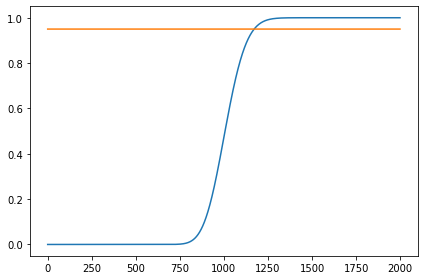

0.9484850832625837


In [17]:
p = 0.1 # вероятность купить подписку
N = [i for i in range(2000)]
#Y = [st.binom(n,p).cdf(100) for n in range(2000)] # вероятности того, что подписку оформят менее 100 клиентов при некотором n
Y = [1-st.binom(n,p).cdf(100) for n in range(2000)] # вероятности того, что подписку оформят >= 100 клиентов при некотором n


#print('Вероятность менее 100 регистраций (вероятность не выполнить план) в зависимости от числа промокодов')
print('Вероятность не менее 100 оформлений подписки (вероятность выполнить план) в зависимости от числа промокодов')
fig, ax = plt.subplots()
ax.clear()
ax.set_xlabel='N'
ax.set_ylabel='Вероятность не менее 100 оформлений подписки (вероятность выполнить план)'
ax.plot(N,Y)
#ax.plot(N, [0.05]*2000)
ax.plot(N, [0.95]*2000)
fig.tight_layout()
plt.show()

print(1-st.binom(1170,p).cdf(100))

На графике изображена вероятность выполнить план (вероятность что подписку продлят не менее 100 пользователей) в зависимости от числа разосланных промокодов. Легко заметить, что эта вероятность монотонно возрастает с ростом числа промокодов, и, начиная примерно с 1170 штук, становится более 95%

Таким образом 1170 является минимальным числом промокодов, обеспечивающим вероятность выполнить план с вероятностью не менее 95% (вероятность неудачи менее 5%).

#### Push-уведомления в мобильном приложении

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40% получивших клиентов. Отдел планирует разослать 11 млн уведомлений. С помощью аппроксимации построим примерный график распределения и оценим вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Ситуация описывается биномильным распределением, но т.к. `p=0.4` близко к 0.5 и N велико, то можно приблизить его нормальным.

Вероятность что уведомление откроет менее 399500 пользователей: 0.15371708296369768


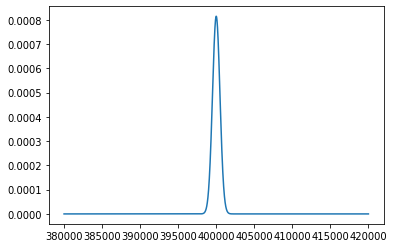

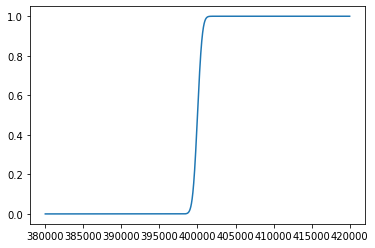

In [18]:
# биномиальное распределение
p = 0.4
N = 1000000
# параметры соответствующего нормального распределения
mu = N * p
sigma = np.sqrt(N * p * (1 - p))

#distr = st.binom(N,p)
distr = st.norm(mu, sigma)

print('Вероятность что уведомление откроет менее 399500 пользователей:', distr.cdf(399500))

x = [i for i in range(380000, 420000)]

plt.plot(x, distr.pdf(x))
plt.show()
plt.plot(x, distr.cdf(x))
plt.show()

Вероятность того что уведомление откроют менее 399500 человек чуть более 15%.

In [19]:
from math import sqrt

# задаём параметры биномиального распределения
n = 1000000
p = 0.4
# зададим параметры нормального распределения равными мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))
# задаём нормальное распределение
distr = st.norm(mu, sigma) 
# считаем вероятность хвоста слева от 399,5 тысяч
result = distr.cdf(399500)
print(result)

0.15371708296369768


## Выводы

В выборку попало 1534 пользователя, среди которых платную подписку имеют 45.6% пользователей.

Наибольшее число пользователей в выборке зарегистрировано в Пятигорске (219), а наименьшее в Москве (168). 
Всего в выборку попали пользователи из 8 городов.

Немного странно что наименьшее число пользователей по городам в выборке именно в Москве. Это либо просто случайность при формировании выборки, либо сервис не может конкурировать с конкурентами в крупном городе, данный вопрос требует дополнительного изучения.

Среди пользователей с платной подпиской минимальная дистанция и максимальное и минимальное время поездки больше чем для бесплатной (1-35 минут для бесплатной и 3-41 для платной; менее 1м для бесплатной и 300м для платной). 
Однако максимальная дистанция для бесплатных подписок больше (7км против 5.5км).

Также отметим, что хотя доля пользователей с платной подпиской 45.6%, 
они совершают почти вдвое меньше поездок чем пользователи с бесплатной подпиской (6500 против 11568)

На основании выборки получено, что с большой вероятностью средний пробег пользователей с платной подпиской действительно не превышает 3130м.

Можно заявить что с большой вероятностью пользователи с подпиской тратят больше времени на поездки чем пользователи без подписки. 

Получено, что в среднем 1 пользователь с подпиской приносит больше прибыли чем 1 пользователь без подписки. В таком случае имеет смысл переманивать пользователей перейти на платный вид подписки, например устраивая акции с промокодами.

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10% пользователей.

Необходимо выяснить какое минимальное количество промокодов необходимо разослать чтобы выроятность не выполнить план была примерно 5%.

**Ответ:** Минимальное число промокодов около 1170 промокодов, тогда вероятность не выполнить план становится менее 5%.

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. 
Известно, что уведомления открывают около 40% получивших клиентов. 
Отдел планирует разослать 11 млн уведомлений. Необходимо оценить вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

**Ответ:** Вероятность того что уведомление откроют менее 399500 чуть более 15%.